## Hodgkin-Huxley model with one channel in response to several voltage-clamps protocols
### Channel identity. ICG id: 2393, ModelDB id: 82849

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt

## Voltage-clamp protocol

In [2]:
prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
p = 4
protocols = \
pd.read_csv('~/Documents/repos/lfi-models/lfimodels/channelomics/protocols/ca_channels/'+prot[p]+'.dat',sep='\t')
protocols = protocols.drop(protocols.columns[-1],axis=1)

# extract voltages and time
protocols1 = protocols.values

V = protocols1[:,1:].T
t = protocols1[:,0]   # attention: time step varies, but we will assume that it is constant
tstep = np.mean(np.diff(t)) # ms

## Parameters and kinetics

In [3]:
# parameters
# celsius = 37    # original temperature
# temp = 23       # reference temperature
# q10 = 2.3       # temperature sensitivity
# tadj = q10**((celsius - temp)/10)

g_L = 3.334e-2 # mS/cm2
E_L = -80 # not sure which one is used in Podlaski et al. 2017, mV

gbar_hva = 1.0 # mS/cm2
# E_Ca = 12.5 * np.log(Ca_o/Ca_i) # mV
E_Ca = 135 # mV

noise_std = 0.01

###############################################################################
# kinetics
def efun(z):
    ind = np.abs(z) < 1e-4
    efun1 = z*1.
    efun1[ind] = z[ind]+1e-5
    efun1[~ind] = z[~ind]
    return efun1

def u_inf(x):
    v1 = x + 24.6
    return 1/(1+np.exp(-efun(v1)/11.3))

def tau_u(x):
    v1 = -0.031*(x+37.1)
    return 1.25*2/(np.exp(v1) + np.exp(-v1))

def z_inf(x):
    v1 = x + 12.6
    return 1/(1+np.exp(efun(v1)/18.9))

tau_z = 420

## Voltage-clamp simulation

In [4]:
t_sim = time.time()

u = np.zeros_like(V)
z = np.zeros_like(V)

u[:,0] = u_inf(V[:,0])
z[:,0] = z_inf(V[:,0])

for i in range(1, t.shape[0]):
    u_inf1 = u_inf(V[:,i-1])+noise_std*np.random.randn()/(tstep**0.5)
    z_inf1 = z_inf(V[:,i-1])+noise_std*np.random.randn()/(tstep**0.5)
    u[:,i] = u_inf1+(u[:,i-1]-u_inf1)*np.exp(-tstep/tau_u(V[:,i-1]))
    z[:,i] = z_inf1+(z[:,i-1]-z_inf1)*np.exp(-tstep/tau_z)
    
print(time.time() - t_sim)


fact_inward = -1 # inward current pre-multiplied by -1 (see page 15 of Podlasky et al. 2017)

I_Ca = fact_inward*gbar_hva*(u**2)*z*(V-E_Ca)
I_Ca = I_Ca/np.max(I_Ca)
# I_L = g_L*(V-E_L)
# I_tot = (I_Ca + I_L)/np.max(I_Ca + I_L)

7.665161848068237


## Plot

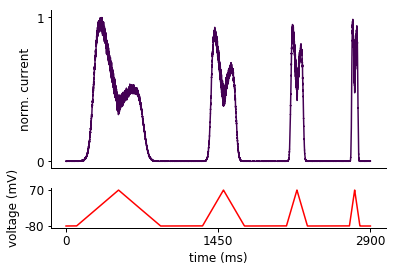

In [5]:
# %matplotlib notebook
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

# scal_y = 1

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t,I_Ca[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_Ca)])
# ax.set_ylim([0,scal_y])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([np.min(V), np.max(V)])

plt.show()

## Checking model implementation against it (attention: discrepancy in temporal resolution)

In [15]:
from lfimodels.channelomics.Channel import Channel
n_params = 8
cython = True
m = Channel(channel_type='ca',n_params=n_params,cython=cython)

import numpy as np
t_sim = time.time()
out = m.gen_single(np.array([24.6, 11.3, -.031, 37.1, 2.5, 12.6, 18.9, 420]))
print(time.time() - t_sim)

import matplotlib.pyplot as plt
%matplotlib inline

N2 = out[prot[p]]['data']
t2 = out[prot[p]]['time']

1.3542420864105225


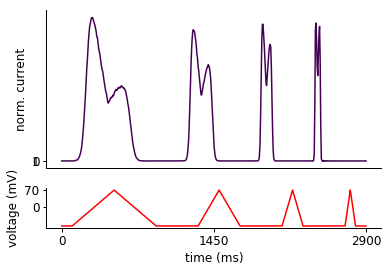

In [16]:
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t2, N2[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_Ca)])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, np.max(V)])

plt.show()